#### Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import shutil
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb

from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

import math

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

seed = 0
np.random.seed(seed)

/home/arsh/anaconda3/envs/torch/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Load and Prepare Data

In [2]:
data = pd.read_json('./Data/train.json')
data['band_1'] = data['band_1'].apply(lambda x : np.array(x).reshape(75, 75))
data['band_2'] = data['band_2'].apply(lambda x : np.array(x).reshape(75, 75))
data['inc_angle'] = pd.to_numeric(data['inc_angle'], errors='coerce')

# data = data.dropna(axis=0, how='any')

In [3]:
band_1_KF = np.concatenate([im for im in data['band_1']]).reshape(-1, 75, 75)
band_2_KF = np.concatenate([im for im in data['band_2']]).reshape(-1, 75, 75)
X_KF = np.stack((band_1_KF, band_2_KF), axis=1)
X_KF = [X_KF, np.array(data['inc_angle']).reshape((len(data), 1))]
y_KF = data['is_iceberg'].values.astype(np.float32)

kfold = 5
y_labels = []
sss = KFold(n_splits=kfold, random_state=0)
for i, (train_index, test_index) in enumerate(sss.split(X_KF[0], X_KF[1], y_KF)):
    y_train_KF, y_valid_KF = y_KF[train_index], y_KF[test_index]
    y_labels.append(y_valid_KF)
y_labels = np.concatenate(y_labels)

In [79]:
# Submissions to be used
sub_list = [54]
sub_results = []
sub_fold_results = []
for sub in sub_list:
    sub_results.append(np.mean(np.loadtxt('./Models/Sub '+str(sub)+'/results.csv', delimiter=','),axis=0))
    sub_fold_results.append(np.loadtxt('./Models/Sub '+str(sub)+'/cv_fold_results.csv', delimiter=','))

In [80]:
y = y_labels

In [81]:
sig = np.vectorize(sigmoid)

In [82]:
sub_fold_results = sig(sub_fold_results)

In [83]:
y_harmonic = 1/np.mean(1/np.array(sub_fold_results), axis=0)

In [84]:
y_geom = np.prod(np.array(sub_fold_results), axis=0)**(1/(len(sub_fold_results)))

In [85]:
print(log_loss(y, y_harmonic), log_loss(y, y_geom), 
      log_loss(y, np.reshape(sub_fold_results, (sub_fold_results.shape[1]))))

0.187773171363 0.187773171363 0.187773171363


In [34]:
# Training Data
X = np.stack(sub_fold_results).T
y = y_labels
X_test = np.stack(sub_results).T

In [15]:
sig = np.vectorize(sigmoid)
X = sig(X)

NameError: name 'X' is not defined

In [36]:
X = np.hstack((X, (np.prod(X, axis=1)**(1/len(X.T))).reshape((len(X), 1))))
X_test = np.hstack((X_test, (np.prod(X_test, axis=1)**(1/len(X.T))).reshape((len(X_test), 1))))

#### XGBoost

In [37]:
xgbscores = []

# Set xgb parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.01
params['silent'] = True
params['max_depth'] = 10
params['subsample'] = 0.7
params['colsample_bytree'] = 0.8
params['colsample_bylevel'] = 0.9
params['seed'] = 99
params['gamma'] = 8
params['eval_metric'] = 'logloss'

In [38]:
# Create a submission file
sub = pd.read_csv('./Data/sample_submission.csv')
sub['is_iceberg'] = np.ones_like(sub['is_iceberg'])

kfold = 5
weights = []
feature_imps = []
sss = KFold(n_splits=kfold, random_state=0)
for i, (train_index, test_index) in enumerate(sss.split(X, y)):
    
    print('[Fold %d/%d]' % (i + 1, kfold))
    X_train, X_valid = X[train_index], X[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    # Convert our data into LGBoost format
    d_train = xgb.DMatrix(X_train, y_train, missing=-1)
    d_valid = xgb.DMatrix(X_valid, y_valid, missing=-1)
    d_test = xgb.DMatrix(X_test, missing=-1)
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]

    # Train the model! We pass in a max of 2,000 rounds (with early stopping after 100)
    # and the custom metric (maximize=True tells xgb that higher metric is better)
    mdl = xgb.train(params, d_train, 5000, watchlist, early_stopping_rounds=170, verbose_eval=200)

    print('[Fold %d/%d Prediction:]' % (i + 1, kfold))
    feature_imps.append(mdl.get_fscore())
    # Predict on our test data
    p_test = mdl.predict(d_test)
    print(mdl.best_score)
#     val_gini = mdl.predict(d_valid_gini)
#     print(gini_normalized(y_valid, val_gini))
#     print(gini_normalized(y_val, mdl.predict(d_valid_2)))
    weight = mdl.best_score
    weights.append(weight)
    sub['is_iceberg'] += p_test*weight

sub['is_iceberg'] = sub['is_iceberg']/np.sum(weights)
print('Mean =', str(np.mean(weights)), '\nStd = ', np.std(weights))

[Fold 1/5]
[0]	train-logloss:0.685156	valid-logloss:0.685122
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 170 rounds.
[200]	train-logloss:0.194323	valid-logloss:0.197194
[400]	train-logloss:0.150516	valid-logloss:0.156306
[600]	train-logloss:0.14557	valid-logloss:0.152746
[800]	train-logloss:0.143766	valid-logloss:0.152042
[1000]	train-logloss:0.142342	valid-logloss:0.151697
[1200]	train-logloss:0.141549	valid-logloss:0.151194
[1400]	train-logloss:0.140695	valid-logloss:0.150853
[1600]	train-logloss:0.140444	valid-logloss:0.150825
Stopping. Best iteration:
[1538]	train-logloss:0.140444	valid-logloss:0.150823

[Fold 1/5 Prediction:]
0.150823
[Fold 2/5]
[0]	train-logloss:0.685122	valid-logloss:0.68499
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 170 rounds.
[200]	train-logloss:0.195521	valid-logloss:0

In [186]:
overall_sub_num = 41
sub.to_csv('./Submissions/Sub '+str(overall_sub_num)+' - fold_model_ensemble -'+'_'.join(map(str, sub_list))+'.csv',
           index=False)

#### Misc 

In [85]:
sub_fold_results = sig(sub_fold_results)

In [60]:
y_harmonic = 1/np.mean((1/sub_fold_results[0], 1/sub_fold_results[1], 1/sub_fold_results[2]), axis=0)

In [61]:
y_geom = (sub_fold_results[0]*sub_fold_results[1]*sub_fold_results[2])**(1/3)

In [62]:
y_am = np.mean(sub_fold_results, axis=0)

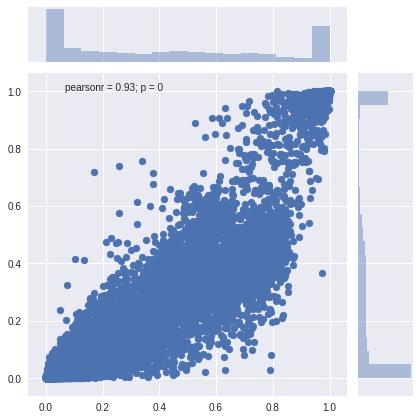

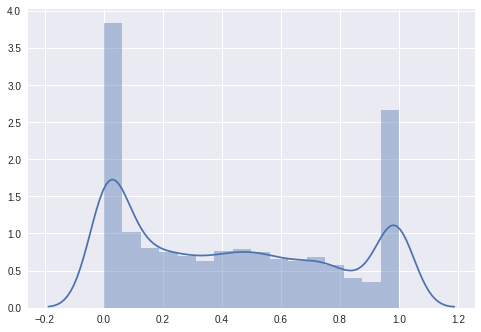

In [39]:
import seaborn as sns
sns.jointplot(sub_results[1], sub_results[0])
plt.show()
sns.distplot(sub_results[1])
plt.show()

In [44]:
pd.DataFrame(np.array(sub_results).T).corr()

,0,1,2
0,1.000000,0.931067,0.960161
1,0.931067,1.000000,0.873093
2,0.960161,0.873093,1.000000


In [63]:
y_geom_harmonic = 1/np.mean((1/y_geom, 1/y_harmonic), axis=0)

In [114]:
import copy
temp = copy.deepcopy(sub_fold_results[0])
temp[(temp>=0.9) & (temp>=0.9)] = 0.99
temp[temp<0.1] = 0.01
# temp[(temp>0.4) & (temp<0.6)] = 0.5

In [115]:
print(log_loss(y, y_harmonic), log_loss(y, y_geom), log_loss(y, y_am), log_loss(y, temp))

0.148578754892 0.149386206193 0.152498427582 0.184369698771


In [286]:
cross_val_score(LogisticRegression(), np.hstack((X, np.log(X), X**(3))), y,
                cv=3, scoring='neg_log_loss').mean()

-0.17091827316332908

In [17]:
cross_val_score(LogisticRegression(), X, y, cv=3, scoring='neg_log_loss').mean()

-0.18073536641984442

In [115]:
modelLogistic = LogisticRegression()
parametersLogistic={'C':(0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,1,10,100,1000),
                   'solver':('newton-cg', 'lbfgs'),
                   'multi_class':('multinomial','ovr')}
gs_Logistic=GridSearchCV(modelLogistic, parametersLogistic, n_jobs=-1)
gs_Logistic=gs_Logistic.fit(X, y)

In [116]:
gs_Logistic.best_params_

{'C': 0.005, 'multi_class': 'ovr', 'solver': 'newton-cg'}

In [26]:
modelLogistic = LogisticRegression()
modelLogistic = modelLogistic.fit(X, y)
y_log = modelLogistic.predict_proba(X)

In [19]:
modelLogistic.coef_

array([[ 2.03518931,  1.87842376,  2.19877137,  1.39811089]])

In [118]:
y_test = modelLogistic.predict_proba(X_test)

In [125]:
sub_num = 28
sub = pd.read_csv('./Data/sample_submission.csv')
sub['is_iceberg'] = y_test[:,0]
sub.to_csv('./Submissions/Sub '+str(sub_num)+' - 5-fold _ Logistic_Ensemble.csv', index=False)